In [4]:
%%capture
!unzip /content/spectrograms2022.zip

In [5]:
%%capture
!pip install torchmetrics
!pip install wandb -q

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import pandas as pd
import os
import sys
import wandb

In [7]:
data_path = '/content/dataset' #looking in subfolder train

spectro_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,301)),
                                  transforms.ToTensor()
                                  ])
)
print(spectro_dataset)

Dataset ImageFolder
    Number of datapoints: 349
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(201, 301), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [8]:
class_map=spectro_dataset.class_to_idx

print("\nCategoría de clase e índice de las imágenes: {}\n".format(class_map))


Categoría de clase e índice de las imágenes: {'cetaceans_allfreq': 0, 'click': 1, 'whistle': 2}



In [9]:
#@title Split data to test and train 20% 80%
train_size = int(0.8 * len(spectro_dataset))
test_size = len(spectro_dataset) - train_size
spectro_train_dataset, spectro_test_dataset = torch.utils.data.random_split(spectro_dataset, [train_size, test_size])

print("Training size:", len(spectro_train_dataset))
print("Testing size:",len(spectro_test_dataset))

Training size: 279
Testing size: 70


In [10]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in spectro_train_dataset]
Counter(train_classes)

Counter({1: 113, 0: 86, 2: 80})

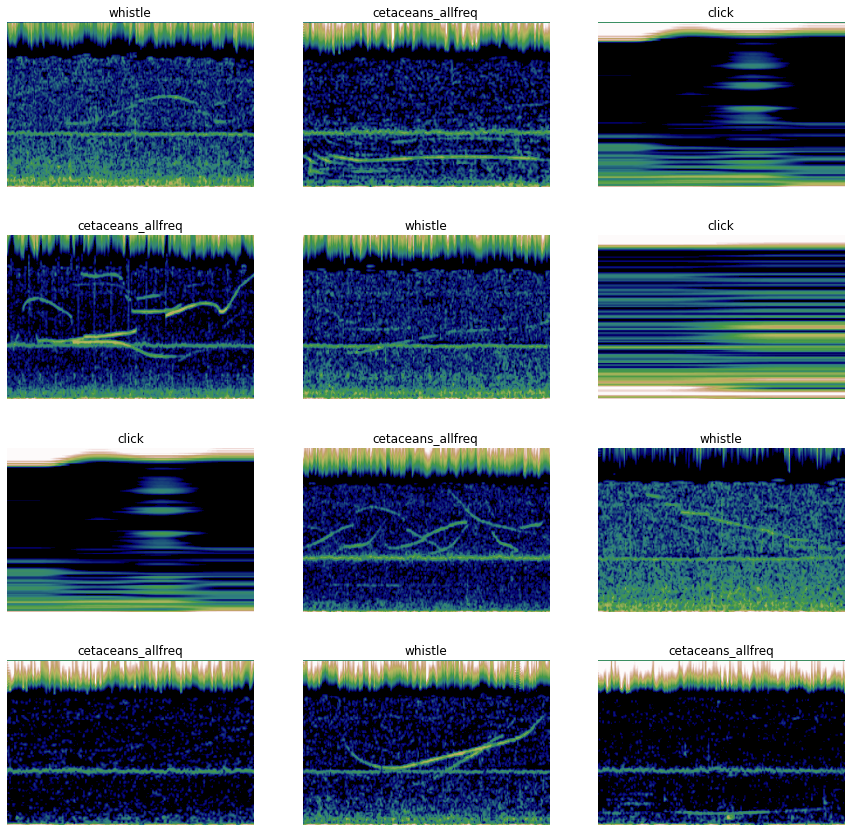

In [147]:
import pylab as pylab
pylab.rcParams['figure.figsize'] = (15, 15)
clases = list(class_map.keys())
f, axes = plt.subplots(4, 3)
for i in range(12):
  index = torch.randint(len(spectro_train_dataset), (1,)).item()
  axes.ravel()[i].imshow(spectro_train_dataset[index][0][0,:,:].numpy(), cmap="gist_earth")
  axes.ravel()[i].title.set_text(clases[spectro_train_dataset[index][1]])
  axes.ravel()[i].axis('off')

In [ ]:
#@title LogIn Wandb
# WandB – Login to your wandb account so you can log all your metrics
!wandb login

wandb: Currently logged in as: sandro_og. Use `wandb login --relogin` to force relogin


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
#@title Hiperparámetros

batch_size = 15
learning_rate = 0.0001
scheduler_step=35
scheduler_gamma = 0.96
epochs = 40

In [ ]:
#@title Dataloaders
train_dataloader = torch.utils.data.DataLoader(
    spectro_train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    spectro_test_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False
)

In [ ]:
#@title Código de  modelo
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(216576, 50)
        self.fc2 = nn.Linear(50, 3)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

In [ ]:
#@title Código training
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma )

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'    Train loss: {loss:>7f}')
            #wandb.log({'Train loss': loss})


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'    Val acc: {(100*correct):>0.1f}%, Val loss: {test_loss:>8f}\n')
    wandb.log({'    Val accuracy': (100*correct), 'val loss': test_loss})

In [ ]:
#@title  Training
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%H:%M:%S")
nombre = "exp_" + dt_string
wandb.init(name =nombre, project="custom_dataset_datathon2022_v2")

config = wandb.config          
config.batch_size = batch_size          
config.test_batch_size = batch_size    
config.epochs = epochs              
config.lr = learning_rate
config.scheduler_step =scheduler_step
config.scheduler_gamma =scheduler_gamma        

for t in range(epochs):
    print(f'Epoch {t+1}')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Val accuracy,▁▁▅▂▂▂▃▅▂▆▆▅▅▆▆▃▆▆▆▅▅▆▆▆▇▇▆▆▇▆█▆▇███████
val loss,█▇▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Val accuracy,80.0
val loss,0.02813


Epoch 1
    Train loss: 1.098769
    Val acc: 42.9%, Val loss: 0.072711

Epoch 2
    Train loss: 1.225614
    Val acc: 51.4%, Val loss: 0.066918

Epoch 3
    Train loss: 1.196890
    Val acc: 54.3%, Val loss: 0.061328

Epoch 4
    Train loss: 0.965690
    Val acc: 55.7%, Val loss: 0.059094

Epoch 5
    Train loss: 1.116218
    Val acc: 64.3%, Val loss: 0.055663

Epoch 6
    Train loss: 1.025789
    Val acc: 67.1%, Val loss: 0.051083

Epoch 7
    Train loss: 0.924492
    Val acc: 70.0%, Val loss: 0.044943

Epoch 8
    Train loss: 0.941217
    Val acc: 71.4%, Val loss: 0.040764

Epoch 9
    Train loss: 0.917904
    Val acc: 78.6%, Val loss: 0.039046

Epoch 10
    Train loss: 1.020648
    Val acc: 80.0%, Val loss: 0.036452

Epoch 11
    Train loss: 0.728473
    Val acc: 81.4%, Val loss: 0.033088

Epoch 12
    Train loss: 0.714082
    Val acc: 77.1%, Val loss: 0.033992

Epoch 13
    Train loss: 0.718889
    Val acc: 78.6%, Val loss: 0.034021

Epoch 14
    Train loss: 0.761218
    Val acc: 

In [ ]:
PATH = './datathon2022.pt'
torch.save(model.state_dict(), PATH)